## Dataset Description

Our focus in this project is on the Bank Account Fraud (BAF)'s main dataset, published at NeurIPS 2022, available on https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data.

This synthetic tabular dataset comprises 1M instances. Each instance represents a credit card application, for which the values of 31 features and the corresponding label is available. The label indicates whether the application is fradulant. The features capture various information associated with the applicant (such as the their age, income, housing status, employment and credit risk score) or the application (such as the proposed credit limit and the month of the application). The dataset contains a combination of numerical (continuous and discrete) and categorical features and some of the features have missing values. A detailed description of the features can be found on https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf.

Quoting authors' claims, the BAF datasets suite, comprising the main dataset considered in this project and its variations, are
- Realistic, based on a present-day real-world dataset for fraud detection;
- Biased, each dataset has distinct controlled types of bias;
- Imbalanced, this setting presents a extremely low prevalence of positive class;
- Dynamic, with temporal data and observed distribution shifts;
- Privacy preserving, to protect the identity of potential applicants we have applied differential privacy techniques (noise addition), feature encoding and trained a generative model (CTGAN).

In [1]:
import os
import numpy as np

import pandas as pd
# Set maximum number of rows and columns shown
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import matplotlib.colors
import joblib
import seaborn as sns
# Define custom colors/cmaps/palettes for visualization purposes.
denim='#6F8FAF'
salmon='#FA8072'
slate_gray = '#404040'
cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",[denim,salmon])
palette = 'colorblind'
sns.set_style('darkgrid')

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, recall_score, make_scorer, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

import warnings
# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DATA_PATH = ''

df = pd.read_csv(os.path.join(DATA_PATH, 'Base.csv'))

target = 'fraud_bool'

X = df.drop(target,axis=1)
y = df[target]

In [3]:
# Train/test split with stratified sampling

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1).copy()
train_copy = pd.concat([X_train, y_train], axis=1).copy()

In [4]:
feature_descriptions = {
    'income' : "Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].",
    'name_email_similarity' : "Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].",
    'prev_address_months_count' : "Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).",
    'current_address_months_count' : "Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).",
    'customer_age' : "Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.",
    'days_since_request' : "Number of days passed since application was done. Ranges between [0, 79] days.",
    'intended_balcon_amount' : "Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).",
    'payment_type': "Credit payment plan type. 5 possible (annonymized) values.",
    'zip_count_4w' : "Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].",
    'velocity_6h' : "Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].",
    'velocity_24h' : "Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].",
    'velocity_4w' : "Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].",
    'bank_branch_count_8w' : "Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].",
    'date_of_birth_distinct_emails_4w' : "Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].",
    'employment_status' : "Employment status of the applicant. 7 possible (annonymized) values.",
    'credit_risk_score' : "Internal score of application risk. Ranges between [−191, 389].",
    'email_is_free' : "Domain of application email (either free or paid).",
    'housing_status' : "Current residential status for applicant. 7 possible (annonymized) values.",
    'phone_home_valid' : "Validity of provided home phone.",
    'phone_mobile_valid' : "Validity of provided mobile phone.",
    'bank_months_count' : "How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).",
    'has_other_cards' : "If applicant has other cards from the same banking company.",
    'proposed_credit_limit' : "Applicant’s proposed credit limit. Ranges between [200, 2000].",
    'foreign_request' : "If origin country of request is different from bank’s country.",
    'source' : "Online source of application. Either browser (INTERNET) or app (TELEAPP).",
    'session_length_in_minutes' : "Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).",
    'device_os' : "Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.",
    'keep_alive_session' : "User option on session logout.",
    'device_distinct_emails_8w' : "Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).",
    'device_fraud_count' : "Number of fraudulent applications with used device. Ranges between [0, 1].",
    'month' : "Month where the application was made. Ranges between [0, 7].",
    'fraud_bool' : "If the application is fraudulent or not."
}

# Exploratory Data Analysis
## Target

In [5]:
print(f"Target: 'fraud_bool'\n\n\
Data type: {y_train.dtype}\n\
Unique values: {y_train.dropna().unique()}\n\
Missing {y_train.isnull().sum()} values")

Target: 'fraud_bool'

Data type: int64
Unique values: [0 1]
Missing 0 values


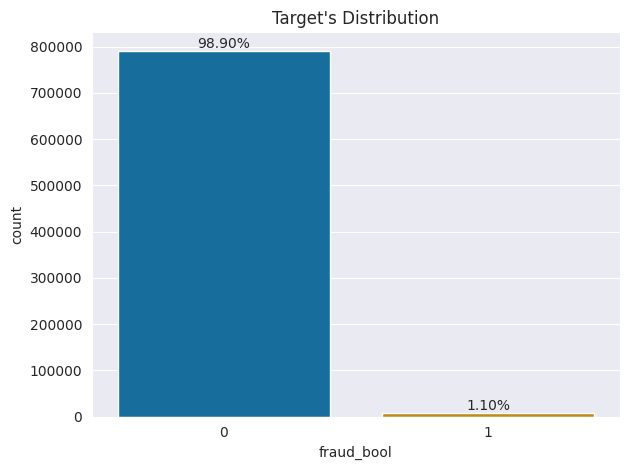

In [6]:
fig = plt.figure(figsize=(6.4,4.8))

# Sort unique values
unique_values = y_train.dropna().unique()
unique_values.sort()

# Value counts
val_counts = y_train.dropna().value_counts()
val_counts = val_counts.reindex(unique_values)

val_counts_pct = val_counts/len(y_train)*100

# Countplot
ax = sns.countplot(x=y_train,palette=palette)
ax.xaxis.grid(False)

# Annotating the bars with value counts percentages
lp_thresh = 1
for i, p in enumerate(ax.patches):
    pct = val_counts_pct.iloc[i]
    ax.annotate(f'{pct:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')
    # Showing count value if rare (less than 1%)
    if pct < lp_thresh:
        ax.annotate(val_counts.iloc[i], (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,10), textcoords='offset points',color='red')
                 
ax.set_title("Target's Distribution")

plt.tight_layout()
plt.show()

## Features Overview

In [7]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
39111,0.7,0.229712,-1,63,50,0.024720,50.674001,AA,1305,12764.326278,6418.672862,5998.527006,7,13,CA,97,1,BC,0,1,24,1,1500.0,0,INTERNET,3.580550,linux,0,1,0,0
822700,0.2,0.928428,199,24,70,0.014153,15.631407,AA,833,9717.635327,6342.913428,4814.609668,1,5,CC,144,0,BD,1,0,20,0,500.0,0,INTERNET,7.087779,other,1,1,0,6
914415,0.1,0.658630,95,2,40,0.045801,-1.410133,AB,237,2201.833206,2753.815567,3076.055489,14,5,CA,87,1,BC,1,1,26,0,200.0,0,INTERNET,0.547804,other,1,1,0,7
581307,0.8,0.774858,-1,122,30,0.005569,-0.539938,AB,895,5377.254660,4551.599208,4223.827504,0,5,CA,206,0,BE,0,1,1,1,500.0,0,INTERNET,4.671407,other,1,1,0,4
603136,0.9,0.993460,103,9,20,0.010832,-0.501067,AB,4105,7428.775954,4872.930234,4250.760719,14,11,CB,114,1,BC,1,1,1,1,200.0,0,INTERNET,9.293206,linux,0,1,0,4


In [8]:
X_train.shape

(800000, 31)

In [9]:
X_train.dtypes

income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                       int64
proposed_credit_limit           

In [10]:
# Numerical (continuous/discrete) and categorical features

num_feats = X_train.select_dtypes(include='number').columns.tolist()

thresh = 25

cont_feats = [feat for feat in num_feats if df[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_feats if df[feat].nunique() < thresh]

cat_feats = X_train.select_dtypes(exclude='number').columns.tolist()

print(f'Features: {X_train.shape[1]}\n\n\
Continuous: {len(cont_feats)}\n\
{cont_feats}\n\n\
Discrete: {len(disc_feats)}\n\
{disc_feats}\n\n\
Categorical: {len(cat_feats)}\n\
{cat_feats}')

Features: 31

Continuous: 14
['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes']

Discrete: 12
['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Categorical: 5
['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [11]:
# Duplicates

print(f'Number of duplicated examples: {len(train.loc[train_copy.duplicated()])}')

Number of duplicated examples: 0


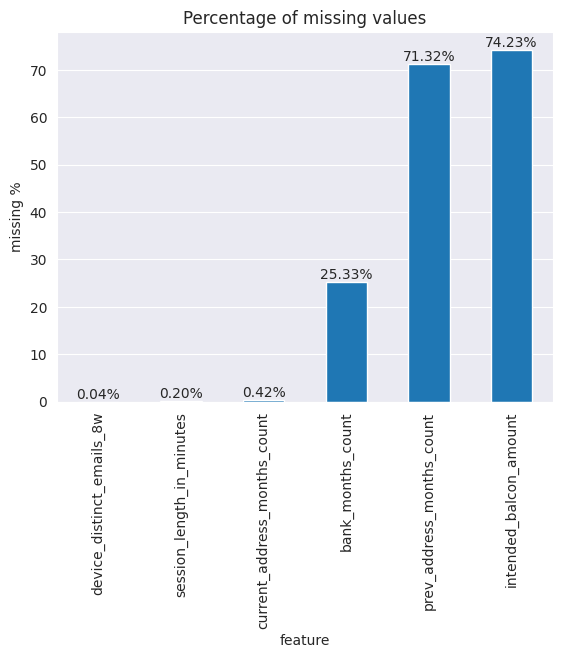

In [12]:
# Missing values
# The datasheet details how the missing values are represented

cols_missing_neg1 = ['prev_address_months_count',
                     'current_address_months_count',
                     'bank_months_count',
                     'session_length_in_minutes',
                     'device_distinct_emails_8w']

X_train[cols_missing_neg1] = X_train[cols_missing_neg1].replace(-1,np.nan)

col_missing_neg = 'intended_balcon_amount'

X_train[col_missing_neg] = X_train[col_missing_neg]\
    .apply(lambda x: np.nan if x < 0 else x)

# Missing values by feature

null_X_train = X_train.isna().sum()/len(X_train)*100

fig = plt.figure(figsize=(6.4,4.8))
ax = null_X_train.loc[null_X_train>0].sort_values()\
    .plot(kind='bar',title='Percentage of missing values')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

ax.set_ylabel('missing %')
ax.set_xlabel('feature')

ax.xaxis.grid(False)

plt.show()

## Customized Description / Plot Functions

We use carefully crafted functions to investigate the features and determine what preprocessing steps to take.

Summary functions: For each feature type (continuous, discrete/binary, and categorical), a summary function is defined. This function returns a customized description of the feature, including the number of missing values, the number of unique values, correlation with target, among other properties.

Plot functions: For each feature type (continuous, discrete/binary, and categorical), some plot functions are crafted to visualize the feature distributions for different target values.

Missing flag plot: For a feature with missing values, this plot depicts the fraud rate in those applications where the feature value is missing and contrasts it with the fraud rate in the applications not missing the feature value. It is meant to examine whether creating a binary 'missing flag' feature based on the feature is warranted. The binary 'missing flag' feature takes value 1 where the feature value is missing, and 0 otherwise.

These function are all combined into a single function `summary()` to avoid repetition later.

In [13]:
# Customized description and plots for any given feature

def summary(feat):
    
    if feat in cont_feats:
        cont_summary(feat)
        cont_plots(feat)
    elif feat in disc_feats:
        disc_summary(feat)
        disc_plots(feat)
    else:
        cat_summary(feat)
        cat_plots(feat)
    
    missing_flag_plot(feat)
    
    return

# Customized description for continuous features

def cont_summary(feat):

    # Create an empty summary
    columns = ['dtype', 'count', 'unique', 'top_value_counts', 'missing_count',
               'missing_percentage','mean', 'std', 'min', 'median', 'max',
               'corr_with_target']
    summary = pd.DataFrame(index=[feat],columns=columns,dtype=float)
    
    # Pull the feature column in question
    col = X_train[feat].copy()
    
    # Basic statistics using the original describe method
    summary.loc[feat,['count','mean', 'std', 'min', 'median', 'max']]\
        = col.describe(percentiles=[.5]).values.transpose()
    
    # Number of unique values
    summary.loc[feat,'unique'] = col.nunique()

    # Missing values count
    summary.loc[feat,'missing_count'] = col.isnull().sum()

    # Missing values percentage
    summary.loc[feat,'missing_percentage'] = col.isnull().sum()/len(col)*100

    # Correlation with target
    summary.loc[feat,'corr_with_target'] = col.corr(y_train)
    
    int_cols = ['count', 'unique', 'missing_count']
    summary[int_cols] = summary[int_cols].astype(int)
    summary = summary.round(2).astype(str)

    # Top 3 value_counts
    value_counts = X_train[feat].value_counts().head(3)
    value_counts.index = value_counts.index.astype(float).to_numpy().round(2)
    summary.loc[feat,'top_value_counts'] = str(value_counts.to_dict())

    # Data type
    summary.loc[feat,'dtype'] = col.dtypes
    
    return display(summary)

# Customized plots for continuous features

def cont_plots(feat,bins='auto'):
    
    n_cols = 3
    fig, axes = plt.subplots(1, n_cols, figsize=(6.4*n_cols, 4.8))
    
    # Histogram
    sns.histplot(data=X_train,
                 x=feat,
                 bins=bins,
                 ax=axes[0],
                 color=slate_gray)
    
    # Box plots with the target as hue
    sns.boxplot(data=X_train,
                x=feat,
                y=y_train,
                ax=axes[1],
                palette=palette,
                orient='h')
    
#     KDE plots with the target as hue
    sns.kdeplot(data=X_train,
                x=feat,
                hue=y_train,
                palette=palette,
                fill=True,
                common_norm=False,
                ax=axes[2])
    
    axes[0].title.set_text('Histogram')
    axes[1].title.set_text('Box Plots')
    axes[2].title.set_text('KDE Plots')
    
    fig.tight_layout()
    plt.show()
    return

# Customized description for discrete features

def disc_summary(feat):
    
    # Create an empty summary
    columns = ['dtype', 'count', 'unique', 'missing_count', 'missing_percentage', 
               'mean', 'std', 'min', 'median', 'max', 'cv', 'corr_with_target']
    summary = pd.DataFrame(index=[feat],columns=columns,dtype=float)
    
    # Pull the feature column in question
    col = X_train[feat].copy()
    
    # Basic statistics using the original describe method
    summary.loc[feat,['count','mean', 'std', 'min', 'median', 'max']]\
    = col.describe(percentiles=[.5]).values.transpose()

    # Number of unique values
    summary.loc[feat,'unique'] = col.nunique()

    # Coefficient of Variation (CV)    
    summary.loc[feat,'cv'] = np.NaN if not col.mean() else col.std()/col.mean()

    # Missing values count
    summary.loc[feat,'missing_count'] = col.isnull().sum()

    # Missing values percentage
    summary.loc[feat,'missing_percentage'] = col.isnull().sum()/len(col)*100
    
    # Correlation with target
    summary.loc[feat,'corr_with_target'] = col.corr(y_train)
    
    int_cols = ['count','unique','missing_count']
    summary[int_cols] = summary[int_cols].astype(int)
    summary = summary.round(2).astype(str)
    
    # Data type
    summary.loc[feat,'dtype'] = col.dtypes
    
    
    return display(summary)

# Customized plots for discrete features

def disc_plots(feat):

    col = X_train[feat].copy()    

    n_rows = 1
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6.4 * n_cols, 4.8 * n_rows))

    # Sort unique values
    unique_values = col.dropna().unique()
    unique_values.sort()

    # Value counts
    val_counts = col.dropna().value_counts()
    val_counts = val_counts.reindex(unique_values)
    val_counts_pct = val_counts/len(col)*100
    
    # Countplot
    sns.countplot(x=col, order=unique_values, palette=palette, ax=axes[0])
    axes[0].xaxis.grid(False)
    
    # Show count value if rare (less than 1%)
    lp_thresh = 1
    for i, p in enumerate(axes[0].patches):
        pct = val_counts_pct.iloc[i]
        axes[0].annotate(f'{pct:.2f}%',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', xytext=(0,0),
                         textcoords='offset points')
        if pct < lp_thresh:
            axes[0].annotate(val_counts.iloc[i],
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom', xytext=(0,10),
                             textcoords='offset points',color='red')
    
    # Barplot
    df = pd.concat([X_train,y_train],axis=1).groupby(feat)[target].mean()*100
    df = df.reindex(unique_values)  # Reindex to match the order
    sns.barplot(x=df.index, y=df.values, palette=palette, ax=axes[1])
    axes[1].set_ylabel('Fraud %')
    axes[1].xaxis.grid(False)

    fig.tight_layout()
    plt.show()
    
    return

# Customized description for categorical features

def cat_summary(feat):
    
    # Create an empty summary
    columns = ['dtype', 'count', 'unique', 'missing_count', 'missing_percentage']
    summary = pd.DataFrame(index=[feat],columns=columns,dtype=float)
    
    # Pull the feature column in question
    col = X_train[feat].copy()
    
    # Count
    summary.loc[feat,'count'] = col.count()

    # Number of unique values
    summary.loc[feat,'unique'] = col.nunique()

    # Missing values count
    summary.loc[feat,'missing_count'] = col.isnull().sum()

    # Missing values percentage
    summary.loc[feat,'missing_percentage'] = col.isnull().sum()/len(col)*100
    
    int_cols = ['count', 'unique', 'missing_count']
    summary[int_cols] = summary[int_cols].astype(int)
    summary = summary.round(2).astype(str)

    # Data type
    summary.loc[feat,'dtype'] = col.dtypes
    
    return display(summary)

# Customized plots for categorical features

def cat_plots(feat):
    
    col = X_train[feat].copy()
    
    n_rows = 1
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6.4 * n_cols, 4.8 * n_rows))
    
    # Value counts
    val_counts = col.dropna().value_counts()
    
    # Unique values
    unique_values = val_counts.index

    # Countplot with sorted order
    sns.countplot(x=col, order=unique_values, palette=palette, ax=axes[0])
    axes[0].xaxis.grid(False)

    val_counts_pct = val_counts/len(col)*100
    
    # Show count value if rare (less than 1%)
    lp_thresh = 1
    for i, p in enumerate(axes[0].patches):
        pct = val_counts_pct.iloc[i]
        axes[0].annotate(f'{pct:.2f}%',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', xytext=(0,0),
                         textcoords='offset points')
        if pct < lp_thresh:
            axes[0].annotate(val_counts.iloc[i],
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom', xytext=(0,10),
                             textcoords='offset points',color='red')
            
    # Barplot with the same order
    df = pd.concat([X_train,y_train],axis=1).groupby(feat)[target].mean()*100
    sns.barplot(x=df.index, y=df.values, order=unique_values, palette=palette, ax=axes[1])
    axes[1].set_ylabel('Fraud %')
    axes[1].xaxis.grid(False)

    fig.tight_layout()
    plt.show()
    
    return

# Plot for the missing flag associated with a feature

def missing_flag_plot(feat):
    col = X_train[feat].isnull().astype(int)

    if not col.sum():
        return

    df = (pd.concat([col,y_train],axis=1).groupby(feat).mean()*100).reset_index()
    cols = [f'MISSING_FLAG_{feat}', 'Fraud %']
    df.columns = cols
    fig = plt.figure(figsize=(6.4, 4.8))
    ax = sns.barplot(data=df,x=cols[0], y=cols[1], palette=palette)
    
    fig.tight_layout()
    plt.show()
    
    return

## Continuous Features

The following code block, which is now commented, provides a detailed one-by-one analysis of the continuous features.

In [14]:
# for feat in cont_feats:
#     print(f"\033[1m Feature:\033[0m '{feat}'\n")
#     print(f'\033[1m Description:\033[0m {feature_descriptions[feat]}')
#     summary(feat)
#     print('-'*45,'\n')

Based on this detailed one-by-one analysis of the continuous features, the following decisions are made:

- 'prev_address_months_count': Fill the missing values with -1, like it was originally. Also create the MISSING_FLAG_prev_address_months_count feature.
- 'current_address_months_count': Fill the missing values with -1, like it was originally. Also create the MISSING_FLAG_prev_address_months_count feature.
- 'intended_balcon_amount': Fill the missing values with -1. Also create the MISSING_FLAG_intended_balcon_amount.
- 'velocity_6h': Replace the negatives with 0.
- 'credit_risk_score': Legality of its use is questionable in practice.
- 'bank_months_count': Fill the missing values with -1, like it was originally. Also create the MISSING_FLAG_bank_months_count feature.
- 'session_length_in_minutes': Fill the missing values with -1, like it was originaly.

For demonstration purposes only, the 'summary' of two of the continuous features is as the following.

 Feature: 'prev_address_months_count'

 Description: Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).


,dtype,count,unique,top_value_counts,missing_count,missing_percentage,mean,std,min,median,max,corr_with_target
prev_address_months_count,float64,229475,373,"{11.0: 9204, 28.0: 8246, 29.0: 8079}",570525,71.32,60.71,63.55,5.0,34.0,383.0,0.02


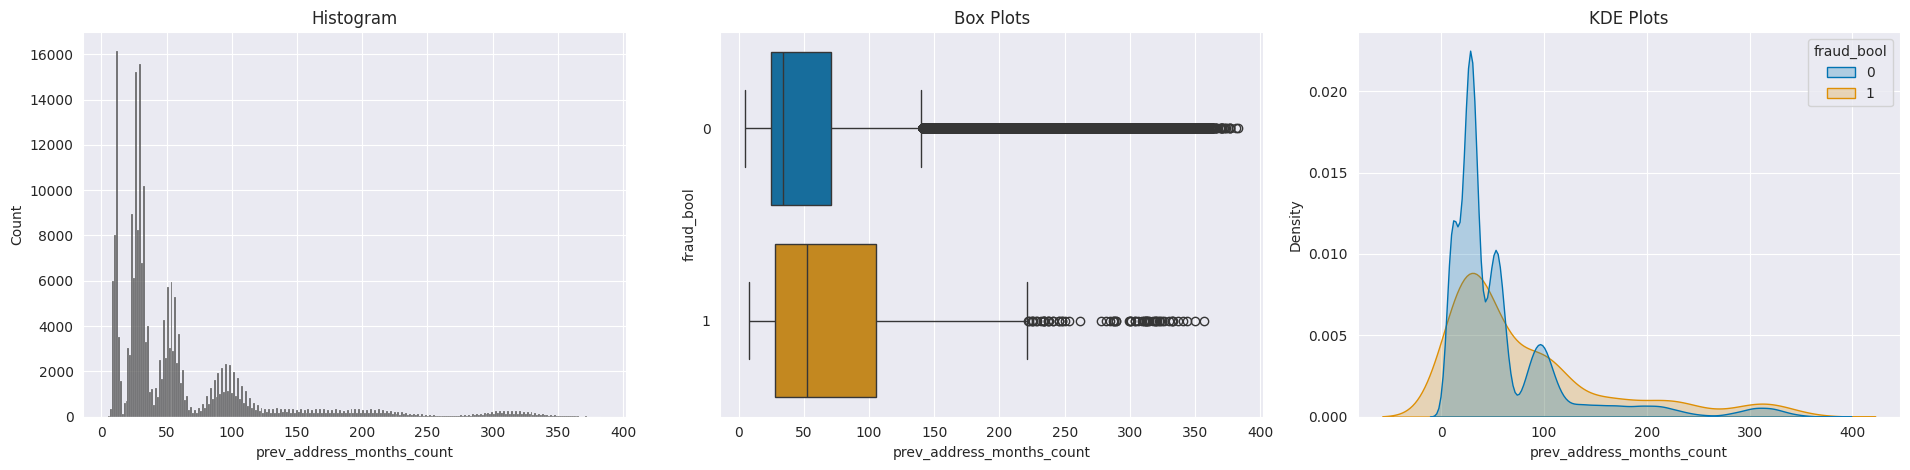

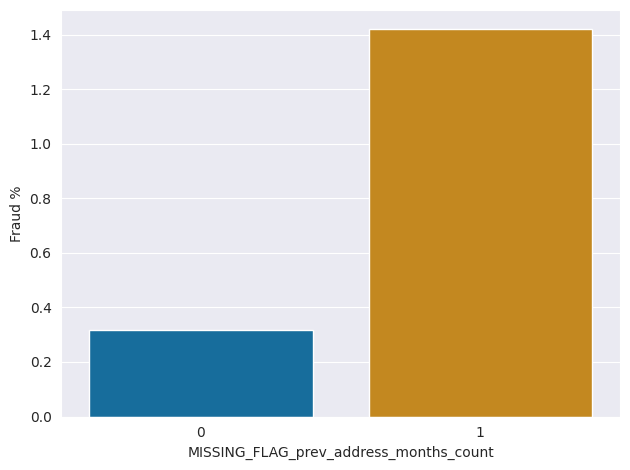

--------------------------------------------- 

 Feature: 'credit_risk_score'

 Description: Internal score of application risk. Ranges between [−191, 389].


,dtype,count,unique,top_value_counts,missing_count,missing_percentage,mean,std,min,median,max,corr_with_target
credit_risk_score,int64,800000,550,"{116.0: 5436, 115.0: 5417, 110.0: 5402}",0,0.0,131.01,69.68,-170.0,122.0,389.0,0.07


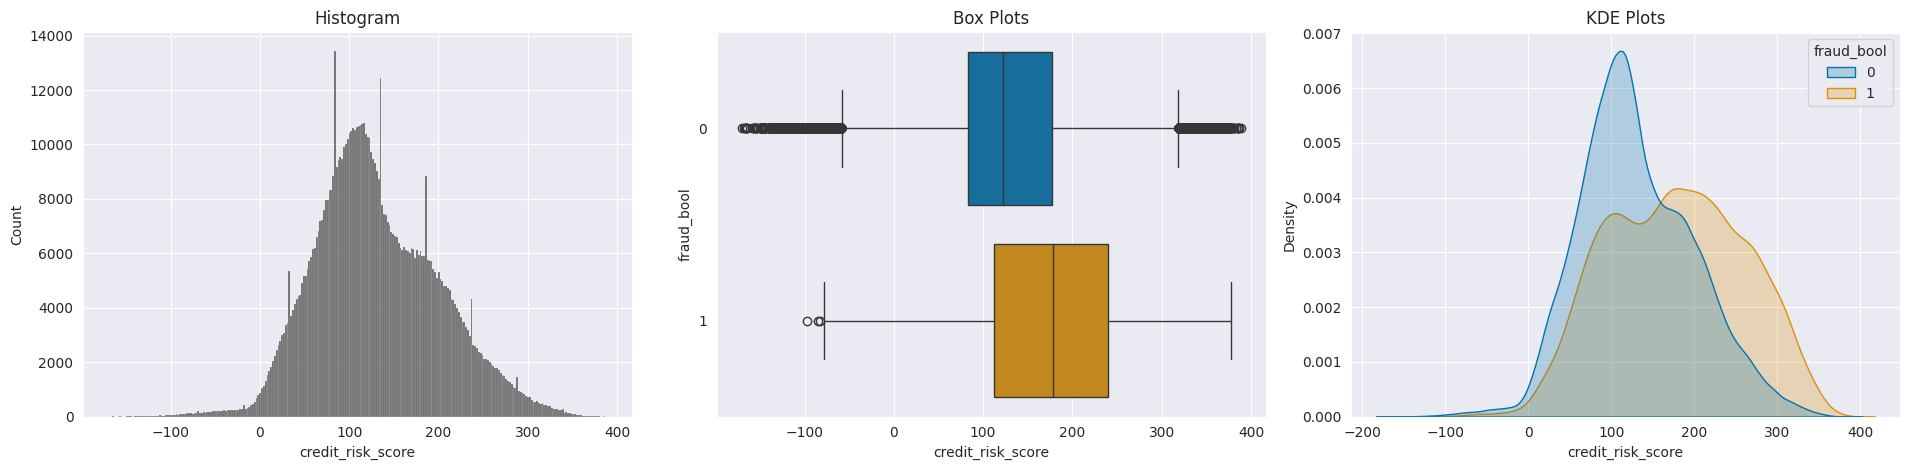

--------------------------------------------- 



In [15]:
select_feats = ['prev_address_months_count', 'credit_risk_score']
for feat in select_feats:
    print(f"\033[1m Feature:\033[0m '{feat}'\n")
    print(f'\033[1m Description:\033[0m {feature_descriptions[feat]}')
    summary(feat)
    print('-'*45,'\n')

## Discrete / Binary Features

The following code block, which is now commented, provides a detailed one-by-one analysis of the discrete and binary features.

In [16]:
# for feat in disc_feats:
#     print(f'\033[1m Feature:\033[0m '{feat}'\n')
#     print(f"\033[1m Description:\033[0m {feature_descriptions[feat]}")
#     summary(feat)
#     print('-'*45,'\n')

Based on this detailed one-by-one analysis of the discrete and binary features, the following decisions are made:

- 'income': Fix the values 0.6 and 0.7.
- 'proposed_credit_limit': Transform into discrete with 5 values:
    - 0: Less than 0 (potential missing values).
    - 1: At least 0, but Less than 500
    - 2: At least 500, but less than 100
    - 3: At least 1000, but less than 1500
    - 4: At least 1500
- 'device_distinct_emails_8w': Fill the missing values with -1, as it was originally. It's also not clear why the value 0 exists.
- 'device_fraud_count': Drop.

For demonstration purposes only, the 'summary' of two of the discrete/binary features is as the following.

 Feature: 'proposed_credit_limit'

 Description: Applicant’s proposed credit limit. Ranges between [200, 2000].


,dtype,count,unique,missing_count,missing_percentage,mean,std,min,median,max,cv,corr_with_target
proposed_credit_limit,float64,800000,12,0,0.0,516.09,487.74,190.0,200.0,2100.0,0.95,0.07


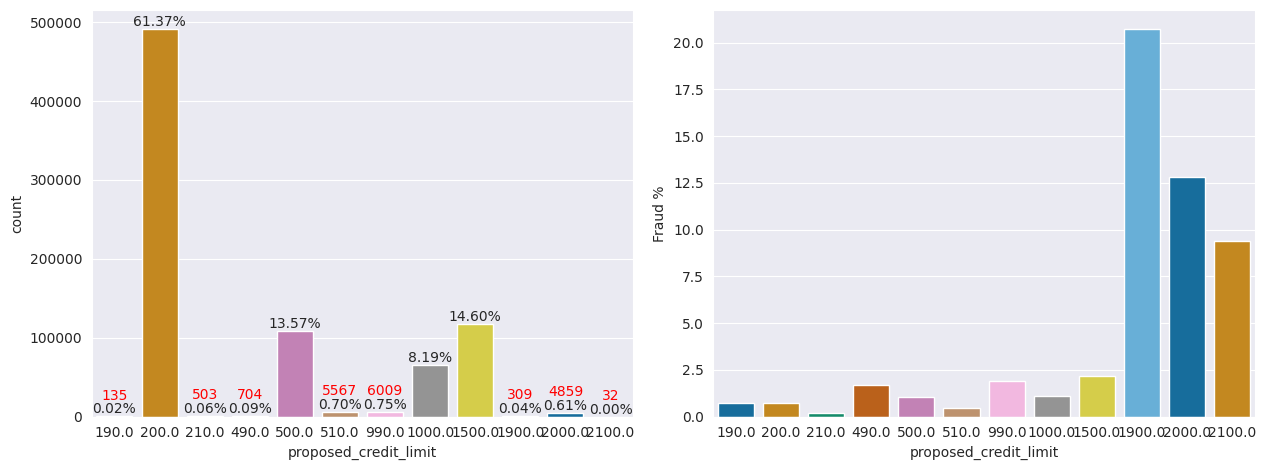

--------------------------------------------- 

 Feature: 'device_distinct_emails_8w'

 Description: Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).


,dtype,count,unique,missing_count,missing_percentage,mean,std,min,median,max,cv,corr_with_target
device_distinct_emails_8w,float64,799710,3,290,0.04,1.02,0.18,0.0,1.0,2.0,0.17,0.04


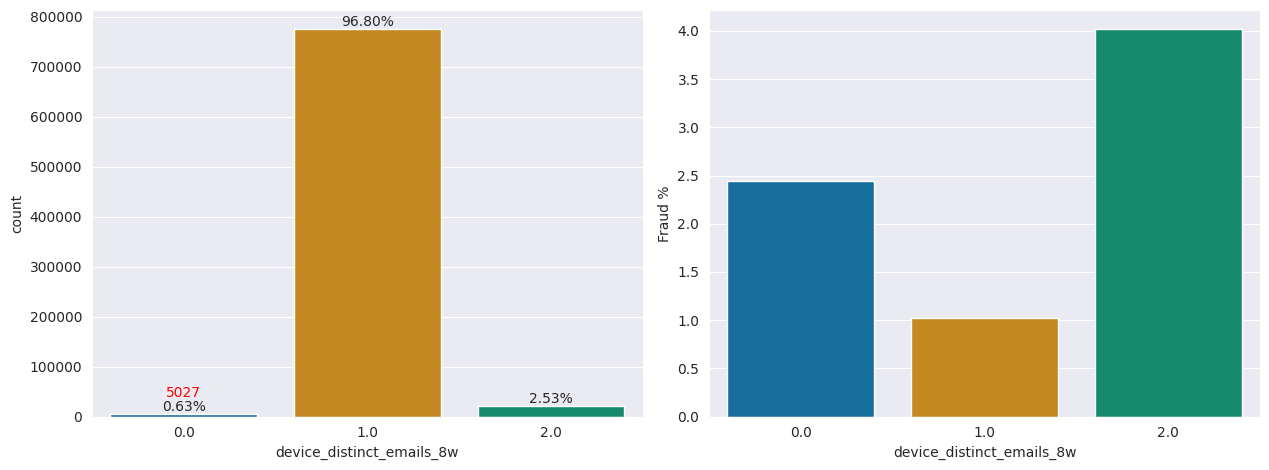

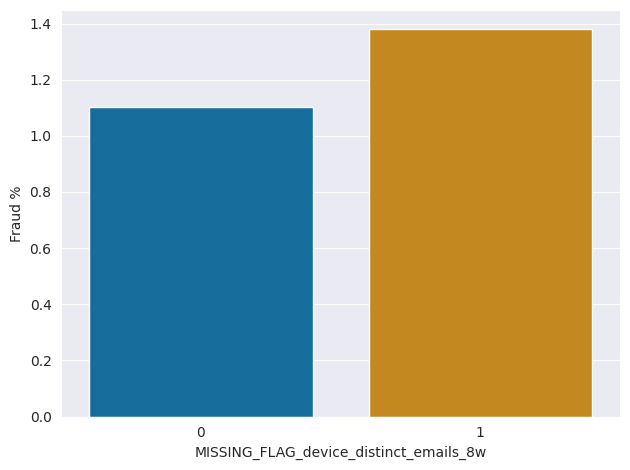

--------------------------------------------- 



In [17]:
select_feats = ['proposed_credit_limit', 'device_distinct_emails_8w']
for feat in select_feats:
    print(f"\033[1m Feature:\033[0m '{feat}'\n")
    print(f'\033[1m Description:\033[0m {feature_descriptions[feat]}')
    summary(feat)
    print('-'*45,'\n')

## Categorical Features

The following code block, which is now commented, provides a detailed one-by-one analysis of the categorical features.

In [18]:
# for feat in cat_feats:
#     print(f"\033[1m Feature:\033[0m '{feat}'\n")
#     print(f'\033[1m Description:\033[0m {feature_descriptions[feat]}')
#     summary(feat)
#     print('-'*45,'\n')

Based on this detailed one-by-one analysis of the categorical features, the following decisions are made:

- 'housing_status': Merge the BD, BF, and BG categories.
- 'source': Drop.
- 'device_os': Merge 'x11' and 'other'.

Furthermore, depending on the classifier which will be employed, one-hot-encoding or a similar transformation of the categorical features would be in order.

For demonstration purposes only, the 'summary' of two of the categorical features is as the following.

 Feature: 'housing_status'

 Description: Current residential status for applicant. 7 possible (annonymized) values.


,dtype,count,unique,missing_count,missing_percentage
housing_status,object,800000,7,0,0.0


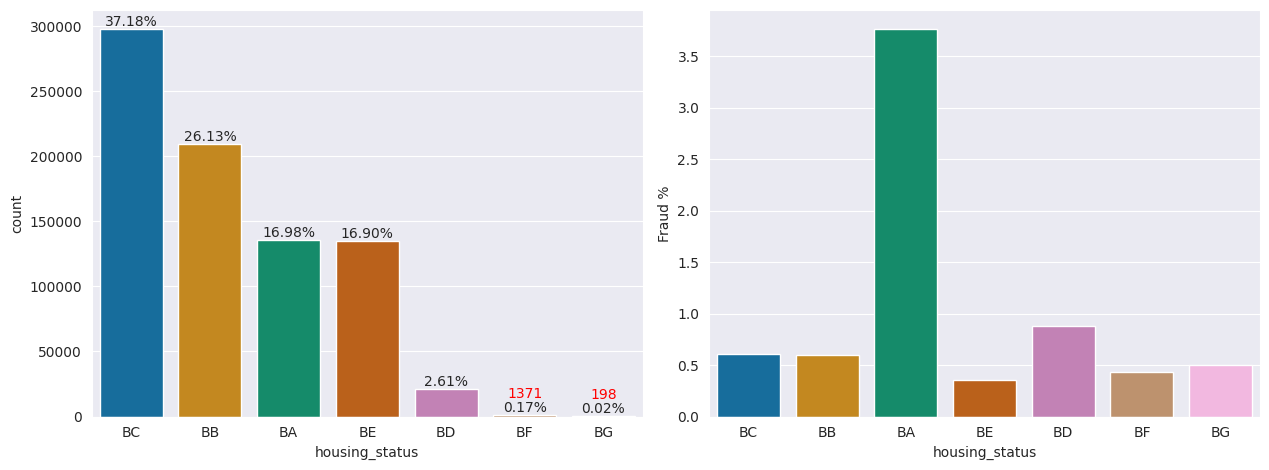

--------------------------------------------- 

 Feature: 'device_os'

 Description: Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.


,dtype,count,unique,missing_count,missing_percentage
device_os,object,800000,5,0,0.0


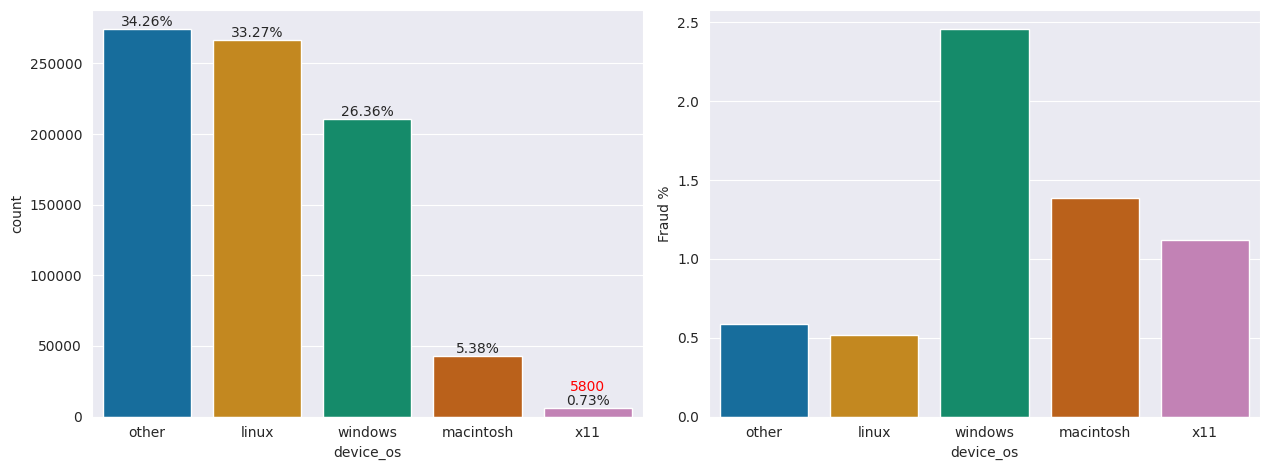

--------------------------------------------- 



In [19]:
select_feats = ['housing_status', 'device_os']
for feat in select_feats:
    print(f"\033[1m Feature:\033[0m '{feat}'\n")
    print(f'\033[1m Description:\033[0m {feature_descriptions[feat]}')
    summary(feat)
    print('-'*45,'\n')

## Correlation Coefficients

In [20]:
# # Correlation coefficients between features

# sns.set_style('white')

# corr = pd.get_dummies(X_train).corr(numeric_only=True)
# fig = plt.figure(figsize=(12.8,11.2))
# ax = sns.heatmap(corr,cmap='viridis')
# ax.set_title('Feature correlation heatmap')

# fig.tight_layout()
# plt.show()
# sns.set_style('darkgrid')

/tmp/ipykernel_18068/4148369802.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


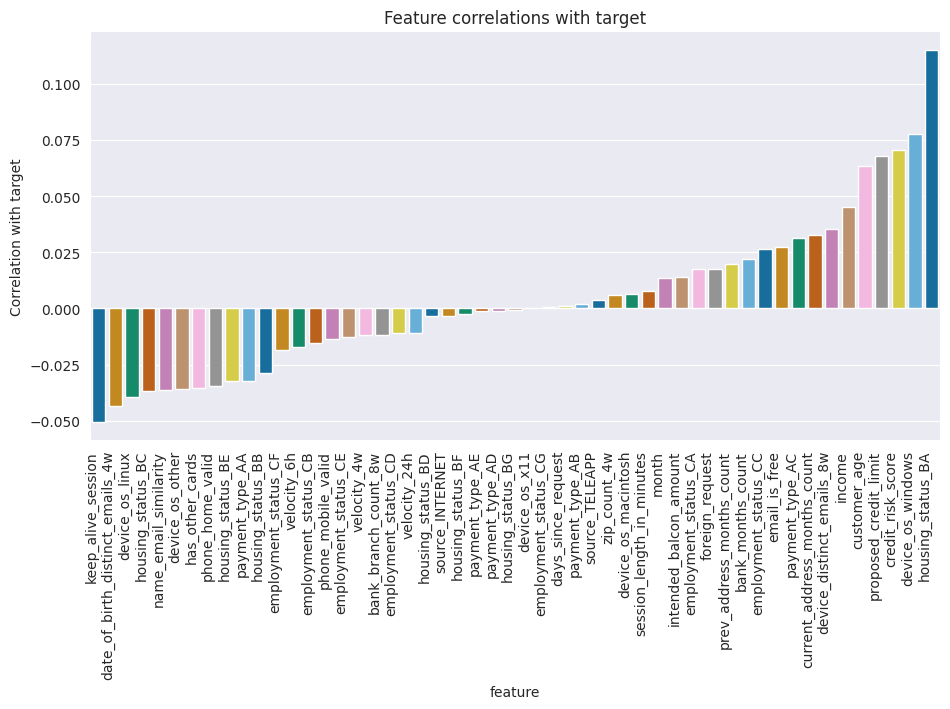

In [21]:
# Correlation coefficient between features and target

fig = plt.figure(figsize=(9.6,7.2))

corr_target = pd.DataFrame(pd.get_dummies(X_train.drop('device_fraud_count',axis=1))
                           .corrwith(y_train)).reset_index()

corr_target.columns = ['feature','target_correlation']
corr_target = corr_target.sort_values(by='target_correlation')

ax = sns.barplot(data=corr_target,x='feature',y='target_correlation',palette=palette)
ax.set_title('Feature correlations with target')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_ylabel('Correlation with target')

fig.tight_layout()
plt.show()

# Customized Evaluation Criterion: Recall @ 5% FPR

## Overview:
The Recall @ 5% FPR (False Positive Rate) criterion is a customized evaluation method tailored specifically for assessing the performance of credit card application fraud detection models. It focuses on measuring the model's ability to correctly identify fraudulent applications while maintaining a low false positive rate.

## Functionality:
The Recall @ 5% FPR function takes two essential inputs: the true labels (`y_true`) indicating whether an application is fraudulent or not, and the predicted probabilities (`y_pred_proba`) generated by the fraud detection model. It calculates the recall rate (true positive rate) at a specified false positive rate of 5%.

## Key Features:
1. **ROC Curve Analysis:** The function computes the Receiver Operating Characteristic (ROC) curve using the true labels and predicted probabilities, allowing for the determination of the trade-off between true positive rate (recall) and false positive rate.
2. **Selection of Specific False Positive Rate:** It selects the operating point on the ROC curve corresponding to a false positive rate of 5%, enabling the calculation of recall at this specific false positive rate.
3. **Performance Metric:** The function returns the recall rate at the chosen false positive rate, providing a quantitative measure of the model's ability to identify fraudulent applications while controlling false positive errors.

## Interpretation:
- A higher recall rate at 5% FPR indicates better model performance, as it signifies that the model can identify a larger proportion of fraudulent applications while maintaining a low false positive rate.
- Conversely, a lower recall rate at 5% FPR suggests potential limitations in the model's ability to detect fraudulent applications effectively without generating excessive false positives.

## Benefits:
- Offers a targeted evaluation metric focusing on the trade-off between recall and false positive rate, which is crucial for fraud detection applications.
- Provides a specific performance measure that aligns with operational requirements, such as maintaining a low false positive rate for efficient fraud management.
- Enables comparison and benchmarking of different models based on their recall performance at a standardized false positive rate.

## Conclusion:
The Recall @ 5% FPR criterion serves as a valuable evaluation metric for credit card application fraud detection models, offering insights into the model's ability to balance the detection of fraudulent applications with the control of false positive errors, ultimately contributing to more effective fraud detection and mitigation strategies.

In [22]:
# Recall @ 5% FPR

def recall_at_5percent_fpr(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    target_fpr = 0.05
    idx = (np.abs(fpr - target_fpr)).argmin()
    return tpr[idx]

# Preprocessing Blocks

Most of the processing blocks that will be employed are self-explanatory. The non-trivial ones are described below.

**MissingFlagger:** This class creates a binary 'missing flag' feature for some of the features with missing values. The values 0 and 1 indicate a non-missing and missing values, respectively.

**CategoricalConverter:** This class converts dtype of categorical features to 'category'. It is meant to be employed in combination with classifiers capable of natively dealing with categorical featuers, LightGBM classifier in particular.

**CustomOneHotEncoder:** This class performs one-hot-encoding, only customized to return a dataframe instead of a numpy array. It is meant to be employed in combination with traditional classifiers such as Logistic Regression.

**CustomScaler:** This class performs standardization, only customized to return a dataframe with column names identical to the original ones.

In [23]:
# Create ColumnDropper class
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed = X_transformed.drop(self.columns_to_drop,axis=1)
        return X_transformed
    
# Create Missing values (-1 or negative) to nan transformer class
class MissingAsNan(BaseEstimator, TransformerMixin):
    def __init__(self, missing_neg1, missing_neg):
        self.missing_neg1 = missing_neg1
        self.missing_neg = missing_neg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.missing_neg1] = X_transformed[self.missing_neg1]\
            .replace(-1, np.nan)
        X_transformed[self.missing_neg] = X_transformed[self.missing_neg]\
            .map(lambda x: np.nan if x < 0 else x)
        return X_transformed

# Create MissingFlagger class
class MissingFlagger(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_flag=None):
        self.columns_to_flag = columns_to_flag
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns_to_flag:
            X_transformed[f'MISSING_FLAG_{col}'] = X_transformed[col].isnull().astype(int)
        return X_transformed

# Create MissingValueFiller class
class MissingValueFiller(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value=0):
        self.fill_value = fill_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed = X_transformed.fillna(self.fill_value)
        return X_transformed
    
# Create IncomeRounder class
class IncomeRounder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['income'] = X_transformed['income'].round(1)
        return X_transformed
    
# Create Merger class to merge some of the categories of categorical features
class Merger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        # proposed_credit_limit
        X_transformed['proposed_credit_limit'] = X_transformed['proposed_credit_limit']\
        .apply(lambda x: min(4,max(0,1+x//500))).astype('int')
        # housing_status
        X_transformed['housing_status'] = X_transformed['housing_status']\
        .apply(lambda x: 'other' if x in {'BD','BF','BG'} else x)  
        # device_os
        X_transformed['device_os'] = X_transformed['device_os']\
        .apply(lambda x: 'other' if x == 'x11' else x)
        return X_transformed

# Create CategoricalConverter class, converting dtype of categorical features to 'category'
class CategoricalConverter(BaseEstimator, TransformerMixin):
    def __init__(self, cat_columns):
        self.cat_columns = cat_columns
        self.categories_ = {}

    def fit(self, X, y=None):
        for col in self.cat_columns:
            self.categories_[col] = X[col].astype('category').cat.categories
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cat_columns:
            X_transformed[col] = pd.Categorical(X_transformed[col],
                                                categories=self.categories_[col], 
                                                ordered=False)
        return X_transformed    
    
# Create CustomOneHotEncoder class for one-hot-encoding, returning a dataframe
class CustomOneHotEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, ohe_columns):
        self.ohe_columns = ohe_columns
        self.ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.feature_names = None

    def fit(self, X, y=None):
        self.ohe.fit(X[self.ohe_columns].astype('category'))
        self.feature_names = list(X.columns)
        return self

    def transform(self, X):
        # One-hot encode the specified columns
        X_ohe = X[self.ohe_columns].copy()
        X_ohe = self.ohe.transform(X_ohe)
        ohe_column_names = self.ohe.get_feature_names_out(self.ohe_columns)
        X_ohe = pd.DataFrame(X_ohe, columns=ohe_column_names, index=X.index)

        # Concatenate the one-hot-encoded columns with the remaining columns
        X_transformed = pd.concat([X.drop(self.ohe_columns,axis=1), X_ohe], axis=1).copy()

        return X_transformed

# Create CustomScalar class for standardization and column name adjustment
# If no columns given, scales all
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_standardize=None):
        self.columns_to_standardize = columns_to_standardize

    def fit(self, X, y=None):
        if self.columns_to_standardize is None:
            self.columns_to_standardize = list(X.columns)
        if self.columns_to_standardize:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.columns_to_standardize])
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        if self.columns_to_standardize:
            X_transformed[self.columns_to_standardize] = self.scaler\
                .transform(X_transformed[self.columns_to_standardize])
        return X_transformed

# Model Building: LightGBM
We now use Light GBM as the classifier after preprocessing the data. The declic evaluation of the model's performance again shows that the model is effective in distinguishing fradulant and non-fradulant applications. The performance in terms of Recall @ 5% FPR and roc_auc_score is also presented, indicating better performance than the case where logistic regression is used as the classifier.

In [25]:
# -------- Preprocessing ----------

cols_to_drop = ['source', 'device_fraud_count']

cols_missing_neg1 = ['prev_address_months_count', 
                     'current_address_months_count', 
                     'bank_months_count', 
                     'session_length_in_minutes', 
                     'device_distinct_emails_8w']
cols_missing_neg = ['intended_balcon_amount']

cols_to_flag = ['prev_address_months_count', 
                'intended_balcon_amount', 
                'bank_months_count']

fill_value = -1

cat_cols = ['payment_type', 
            'employment_status', 
            'housing_status', 
            'device_os', 
            'device_distinct_emails_8w']

lgbm_preprocessor = make_pipeline(ColumnDropper(cols_to_drop),
                                  MissingAsNan(cols_missing_neg1,cols_missing_neg),
                                  MissingFlagger(cols_to_flag),
                                  MissingValueFiller(fill_value),
                                  IncomeRounder(),
                                  Merger(),
                                  CategoricalConverter(cat_cols)
                                 )

X = train_copy.iloc[:,:-1].copy()
y = train_copy.iloc[:,-1].copy()

# Preprocess the data
X_processed = lgbm_preprocessor.fit_transform(X)
X_processed.dtypes

income                                     float64
name_email_similarity                      float64
prev_address_months_count                  float64
current_address_months_count               float64
customer_age                                 int64
days_since_request                         float64
intended_balcon_amount                     float64
payment_type                              category
zip_count_4w                                 int64
velocity_6h                                float64
velocity_24h                               float64
velocity_4w                                float64
bank_branch_count_8w                         int64
date_of_birth_distinct_emails_4w             int64
employment_status                         category
credit_risk_score                            int64
email_is_free                                int64
housing_status                            category
phone_home_valid                             int64
phone_mobile_valid             


Recall @ 5% FPR:
- Validation: 0.5337110481586402
- Test: 0.5480507706255666

roc_auc_score:
- Validation:     0.8908360507657461
- Test: 0.894981519230549


/tmp/ipykernel_12918/3131494747.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


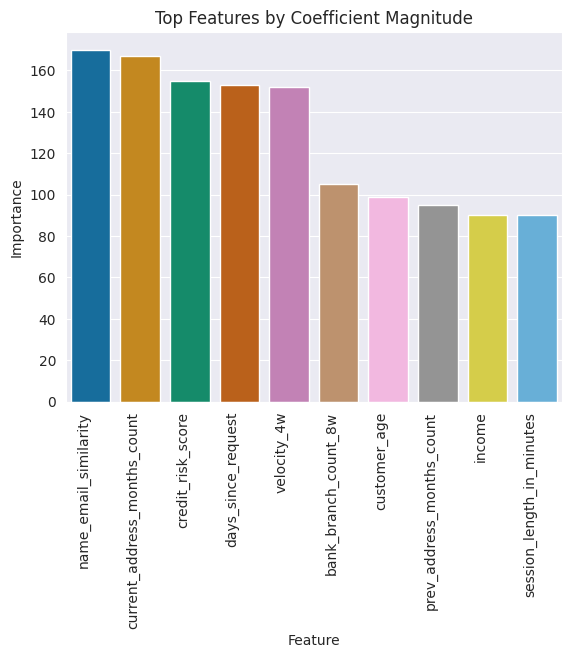

In [ ]:
X_test_processed = lgbm_preprocessor.transform(X_test)

# Train/validation split with stratified sampling
X_train, X_val, y_train, y_val = train_test_split\
    (X_processed, y, test_size=0.2, random_state=42, stratify=y)

# -------- Training and Prediction ----------

# Define LGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves':17,
    'learning_rate': 0.05,
    'verbose': -1,
    'early_stopping_rounds': 250
}

# Create dataset for LGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

# Train the model
model = lgb.train(params, lgb_train, num_boost_round=1000,
                  valid_sets=[lgb_train, lgb_val])

joblib.dump(model, 'bankingfraudmodel.pkl')
# # Make probability predictions on train and test
y_pred_train_proba = model.predict\
    (X_train, num_iteration=model.best_iteration, raw_score=True)
y_pred_val_proba = model.predict\
    (X_val, num_iteration=model.best_iteration, raw_score=True)
y_pred_test_proba = model.predict\
    (X_test_processed, num_iteration=model.best_iteration)

# -------- Performance --------

# Training performance
recall_train = recall_at_5percent_fpr(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Validation performance
recall_val = recall_at_5percent_fpr(y_val, y_pred_val_proba)
roc_auc_val = roc_auc_score(y_val, y_pred_val_proba)

# Test performance
recall_test = recall_at_5percent_fpr(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Print Recall @ 5% FPR for train, validation and test
print(f'\nRecall @ 5% FPR:\n- Validation: {recall_val}\n- Test: {recall_test}')

# Print roc_auc_score for train, validation and test
print(f'\nroc_auc_score:\n- Validation: \
    {roc_auc_val}\n- Test: {roc_auc_test}')


    
# -------- Feature Importance --------

# Get feature importances
feature_importance = model.feature_importance()
    
# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': X_processed.columns,
                                      'Coefficient': feature_importance})

# Number of top features to plot
num_to_plot = 10

# Sort the DataFrame by the absolute value of coefficients
feature_importance_df['Abs_Coefficient'] =\
    feature_importance_df['Coefficient'].abs()
sorted_feature_importance_df = feature_importance_df.sort_values\
    (by='Abs_Coefficient', ascending=False).head(num_to_plot)

# Plot top features by coefficient magnitude
ax = sns.barplot(sorted_feature_importance_df,
                 x='Feature',y='Coefficient',palette=palette)
ax.set_title('Top Features by Coefficient Magnitude')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')

fig.tight_layout()
plt.show()